# Analyzing Negative Google Play Store Reviews using Latent Dirichlet Allocation

![Word Cloud](wordcloud.png)

# Project Overview
As a personal project, this notebook aims to analyze negative reviews from the Google Play Store to better understand user complaints and identify recurring issues. This analysis isn't specific to any app, it's a general analysis of negative reviews from the Google Play Store.


# Dataset
The dataset contains reviews from the Google Play Store, including the following columns:

'content': The text content of each review.
'score': The score assigned to the review by the user, ranging from 1 to 5.
For this analysis, we will focus on the reviews with scores of 1 or 2, which represent the most negative feedback.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import gensim



In [2]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))


# no of top words
no_top_words = 15

# Variables for coherence score calculation
start_topics = 2
limit_topics = 50
step_topics = 1

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha()]
    lemmatized_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    return ' '.join(lemmatized_tokens)

# Function to compute coherence score
def compute_coherence_score(model, texts, dictionary, coherence='c_v'):
    corpus = [dictionary.doc2bow(text) for text in texts]
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
    return coherence_model.get_coherence()

def compute_coherence_values(start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list, coherence_values


## Data Loading and Exploration
We have loaded the reviews dataset and displayed the first few rows to understand its structure.


In [3]:
# Load the reviews dataset and preview it
import os
df_list = []
for file in os.listdir("data"):
    temp_df = pd.read_csv(f"data/{file}")
    df_list.append(temp_df[["content", "score"]])
reviews = pd.concat(df_list, ignore_index=True)
del df_list, temp_df
reviews.head()

,content,score
0,I cannot open the app anymore,1
1,I have been begging for a refund from this app...,1
2,Very costly for the premium version (approx In...,1
3,"Used to keep me organized, but all the 2020 UP...",1
4,Dan Birthday Oct 28,1


## Preprocess the negative reviews

### Data Preprocessing
We are filtering out negative reviews (scores 1 or 2) for further analysis.


In [4]:
# Filter negative reviews (having a score of 1 or 2)
negative_reviews_tmp = reviews[reviews['score'] <= 2]["content"]
negative_reviews_tmp.head()

# check for nulls
print("Nulls: ", negative_reviews_tmp.isnull().sum())

# drop nulls
negative_reviews_tmp = negative_reviews_tmp.dropna()

# check again
print("Nulls: ", negative_reviews_tmp.isnull().sum())

# check for duplicates
print("Duplicates: ", negative_reviews_tmp.duplicated().sum())

# drop duplicates
negative_reviews_tmp = negative_reviews_tmp.drop_duplicates()

# check again
print("Duplicates: ", negative_reviews_tmp.duplicated().sum())

Nulls:  8
Nulls:  0
Duplicates:  4679
Duplicates:  0


In [5]:
negative_reviews_tmp.head()

0                        I cannot open the app anymore
1    I have been begging for a refund from this app...
2    Very costly for the premium version (approx In...
3    Used to keep me organized, but all the 2020 UP...
4                                  Dan Birthday Oct 28
Name: content, dtype: object

In [6]:
negative_reviews_tmp.info()

<class 'pandas.core.series.Series'>
Index: 52300 entries, 0 to 212494
Series name: content
Non-Null Count  Dtype 
--------------  ----- 
52300 non-null  object
dtypes: object(1)
memory usage: 817.2+ KB


### Text Preprocessing
We have preprocessed the negative reviews by converting them to lowercase, tokenizing, and removing stopwords and non-alphabetic tokens.


In [7]:
negative_reviews_cleaned = negative_reviews_tmp.apply(preprocess_text)

preprocessed_reviews = pd.DataFrame({"review": negative_reviews_cleaned})
preprocessed_reviews.head()

,review
0,open app anymore
1,begging refund app month nobody replying
2,costly premium version approx indian rupee per...
3,used keep organized update made mess thing cud...
4,dan birthday oct


## TF-IDF Vectorization
We have converted the cleaned text into numerical features using TF-IDF vectorization, which is suitable for clustering analysis.


In [8]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_reviews["review"])


## Latent Dirichlet Allocation

### Coherence Score

Optimal number of topics: 37
Topic 0:
sign cant login account ca open app create let even wrong wo use hell unable
Topic 1:
whatsapp status plz low acc online fast scammer official logging showing helpful problem please active
Topic 2:
updating horrible mode dark ap emojis theme nowadays starting sided chinese asking khan band app
Topic 3:
seen hacked task app routine comment date activity frustrating time inconvenient pic west dm technical
Topic 4:
end suck encryption messenger remove opening note app buggy annoying update stupid encrypted message please
Topic 5:
boring difficult unsubscribe god app installed bias sd bugging world mistake resolution glitching sick frequent
Topic 6:
slow hai elon hi nhi ho musk open app nahi bekar bhi ha okay ka
Topic 7:
password reminder reset forgot requires disturbing app correct kannada email intrusive change incorrect set username
Topic 8:
much version pro aap ad tree buy friendly user app ruined free add space channel
Topic 9:
crashing twitter ru

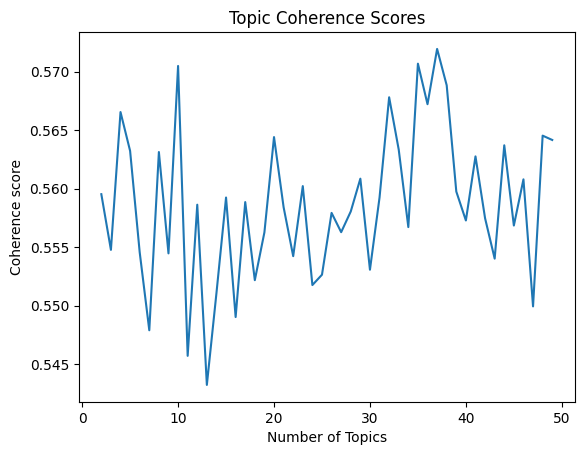

In [9]:
# Prepare data for gensim
texts = [review.split() for review in preprocessed_reviews['review']]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Compute coherence scores
model_list, coherence_values = compute_coherence_values(start_topics, limit_topics, step_topics)

# Plot coherence scores
plt.plot(range(start_topics, limit_topics, step_topics), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.title("Topic Coherence Scores")

# Find the optimal number of topics
optimal_num_topics = range(start_topics, limit_topics, step_topics)[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# Use the optimal number of topics for the final LDA model
lda = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda.fit(tfidf_matrix.toarray())

# Display topics using the existing display_topics function
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

In [10]:
# Use the optimal number of topics for the final LDA model
lda = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda.fit(tfidf_matrix.toarray())

# Display topics using the existing display_topics function
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)
# Function to display topics
# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print("Topic %d:" % (topic_idx))
#         print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
sign cant login account ca open app create let even wrong wo use hell unable
Topic 1:
whatsapp status plz low acc online fast scammer official logging showing helpful problem please active
Topic 2:
updating horrible mode dark ap emojis theme nowadays starting sided chinese asking khan band app
Topic 3:
seen hacked task app routine comment date activity frustrating time inconvenient pic west dm technical
Topic 4:
end suck encryption messenger remove opening note app buggy annoying update stupid encrypted message please
Topic 5:
boring difficult unsubscribe god app installed bias sd bugging world mistake resolution glitching sick frequent
Topic 6:
slow hai elon hi nhi ho musk open app nahi bekar bhi ha okay ka
Topic 7:
password reminder reset forgot requires disturbing app correct kannada email intrusive change incorrect set username
Topic 8:
much version pro aap ad tree buy friendly user app ruined free add space channel
Topic 9:
crashing twitter rubbish keep app habit delete t

## Generate a Word Cloud
Next, we generate a word cloud from the cleaned text of negative reviews to visualize the most frequent terms.

In [11]:
# from wordcloud import WordCloud

# preprocessed_reviews

# # Combine all cleaned reviews into a single string
# combined_text = ' '.join(preprocessed_reviews['review'])

# # Generate the word cloud
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

# wordcloud.to_file("wordcloud.png")

### Conclusion

LDA (Latent Dirichlet Allocation) offers unique advantages for text analysis, each serving different purposes.

**LDA (Latent Dirichlet Allocation)**:
- **Broader Topics**: LDA is good at discovering overarching themes within the text data. It provides a probabilistic distribution of words over topics, which helps to understand the general content and context of the reviews.
- **Insights**: By identifying these broader topics, LDA allows us to gain insights into the main themes discussed in the reviews, such as common issues with notifications, login problems, or feature requests.

The optimal number of topics was found to be 37, with the following topics being displayed. 

Some of the topics identified were:

- Topic 0: Login and Account Issues
- Topic 1: Social Media and Messaging Issues
- Topic 2: App Interface and Theme Issues
- Topic 3: Hacked Accounts and Security Concerns

These topics provide a high-level overview of the main themes in the reviews, which can be used to improve the app and address common issues.
